In [1]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '1'

import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import pandas as pd

from sklearn.model_selection import train_test_split
import pickle
from tqdm.notebook import tqdm 
import pyarrow as pa
import pyarrow.parquet as pq
import torch
from sklearn.metrics import confusion_matrix
import seaborn as sns
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score
import sys
import copy

sys.path.append('..')
from utils.preprocess import NDF

2024-05-24 23:13:51.148688: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


# Combined approach

In [2]:
from imblearn.over_sampling import SMOTE

input_data = {
    'benign': '../feature-extraction/floor/benign_2312.parquet',
    'malign': '../feature-extraction/floor/misp_2402.parquet'
}

dataset = NDF("svm", True, input_data=input_data, one_line_processing=False)

# Assuming dataset['features'] and dataset['labels'] are already tensors
X = dataset['features'].numpy()  # Convert tensors to numpy arrays if possible
y = dataset['labels'].numpy()

# Convert numpy arrays to DataFrames to use scikit-learn tools for preprocessing
X_df = pd.DataFrame(X)
y_df = pd.Series(y)

# Split dataset
X_train, X_test, y_train, y_test = train_test_split(X_df, y_df, test_size=0.2, random_state=42)

2024-05-24 23:13:57,459 - utils.preprocess - INFO - Benign dataset path: ../feature-extraction/floor/benign_2312.parquet
2024-05-24 23:13:57,461 - utils.preprocess - INFO - Malign dataset path: ../feature-extraction/floor/misp_2402.parquet


Malign dataset path: ../feature-extraction/floor/misp_2402.parquet
Benign dataset path: ../feature-extraction/floor/benign_2312.parquet


2024-05-24 23:13:58,357 - utils.preprocess - INFO - Number of records in benign dataset: 462192
2024-05-24 23:13:58,364 - utils.preprocess - INFO - Number of records in malign dataset: 110311
2024-05-24 23:14:00,264 - utils.preprocess - INFO - Total percentage of missing values in benign dataset: 0.19%
2024-05-24 23:14:00,268 - utils.preprocess - INFO - Total percentage of missing values in malign dataset: 0.33%
2024-05-24 23:14:02,445 - utils.preprocess - INFO - Decision tree model saved to models/malware_decision_tree_model.joblib
2024-05-24 23:14:02,481 - utils.preprocess - INFO - New feature 'dtree_prob' created from decision tree predictions.
2024-05-24 23:14:02,527 - utils.preprocess - INFO - Decision Tree Train Accuracy: 0.95
2024-05-24 23:14:02,529 - utils.preprocess - INFO - Decision Tree Test Accuracy: 0.92
2024-05-24 23:14:03,780 - utils.preprocess - INFO - Decision Tree Cross-Validation Scores: [0.91238734 0.91511214 0.91835237]
2024-05-24 23:14:03,783 - utils.preprocess - 


Dataset Subset:
Name: dataset_../feature-extraction/floor/benign2312_../feature-extraction/floor/misp2402_2024-05-24.parquet
Features:
   Feature_0  Feature_1  Feature_2  Feature_3  Feature_4  Feature_5  \
0        0.0        0.0        0.0        1.0        1.0        3.0   
1        1.0        1.0        2.0        0.0       -1.0        0.0   
2        0.0        0.0        0.0        1.0        0.5        3.0   
3        0.0        1.0        2.0        1.0        0.0        1.0   
4        0.0        0.0        0.0        0.0       -1.0        0.0   
5        0.0       -1.0        0.0        0.0       -1.0        0.0   
6        0.0        0.0        0.0        0.0       -1.0        0.0   
7        0.0        0.0        0.0        1.0        0.0        3.0   
8        0.0        0.0        0.0        5.0        0.0        2.0   
9        0.0        2.0        0.0        1.0        0.5        0.0   

   Feature_6  Feature_7  Feature_8  Feature_9  ...  Feature_167  Feature_168  \
0 

# SVM model, params defined from tuning process

In [5]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.svm import SVC

svm_x_train = copy.deepcopy(X_train)
svm_x_test = copy.deepcopy(X_test)
svm_y_train = copy.deepcopy(y_train)
svm_y_test = copy.deepcopy(y_test)

# Function to handle non-numeric data
# def handle_non_numeric_data(df):
#     le = LabelEncoder()
#     for column in df.columns:
#         if df[column].dtype == object:
#             df[column] = le.fit_transform(df[column].astype(str))
#     return df

# # Apply the function to both train and test dataframes
# svm_x_train = handle_non_numeric_data(svm_x_train)
# svm_x_test = handle_non_numeric_data(svm_x_test)

# Subsample the training data
svm_x_train, _, svm_y_train, _ = train_test_split(
    svm_x_train, svm_y_train, test_size=0.2, random_state=42, shuffle=True, stratify=svm_y_train
)

print(f"After Subsampling - svm_x_train: {len(svm_x_train)}, svm_y_train: {len(svm_y_train)}")

# Fill NaNs with zero (to ensure there are no NaNs after encoding)
svm_x_train.fillna(0, inplace=True)
svm_x_test.fillna(0, inplace=True)
svm_y_train.fillna(0, inplace=True)
svm_y_test.fillna(0, inplace=True)

# Convert to numpy arrays
svm_x_train = np.array(svm_x_train)
svm_x_test = np.array(svm_x_test)
svm_y_train = np.array(svm_y_train)
svm_y_test = np.array(svm_y_test)

# Convert logical values False and True to 0 and 1
svm_x_train = np.where(svm_x_train == False, 0, np.where(svm_x_train == True, 1, svm_x_train))
svm_x_test = np.where(svm_x_test == False, 0, np.where(svm_x_test == True, 1, svm_x_test))

# Scaling
scaler = MinMaxScaler()
svm_x_train = scaler.fit_transform(svm_x_train)
svm_x_test = scaler.transform(svm_x_test)

# Define SVM model parameters and train
params = {
    "C": 59,
    "gamma": 0.1,
    "kernel": "rbf",
    "random_state": 42,
    "class_weight": "balanced"
}
model = SVC(**params, verbose=True)
model.fit(svm_x_train, svm_y_train)

After Subsampling - svm_x_train: 16602, svm_y_train: 16602


[LibSVM]...........*......*
optimization finished, #iter = 17258
obj = -13410.780044, rho = -3.259450
nSV = 1514, nBSV = 193
Total nSV = 1514


SVC(C=59, class_weight='balanced', gamma=0.1, random_state=42, verbose=True)

True Negatives (TN): 4222
False Positives (FP): 35
False Negatives (FN): 52
True Positives (TP): 880

False Positive Rate (FPR): 0.00822175240779892
True Positive Rate (TPR): 0.944206008583691 (also known as Recall)

F1 Score: 0.9529

Classification Report:
              precision    recall  f1-score   support

         0.0     0.9878    0.9918    0.9898      4257
         1.0     0.9617    0.9442    0.9529       932

    accuracy                         0.9832      5189
   macro avg     0.9748    0.9680    0.9713      5189
weighted avg     0.9831    0.9832    0.9832      5189



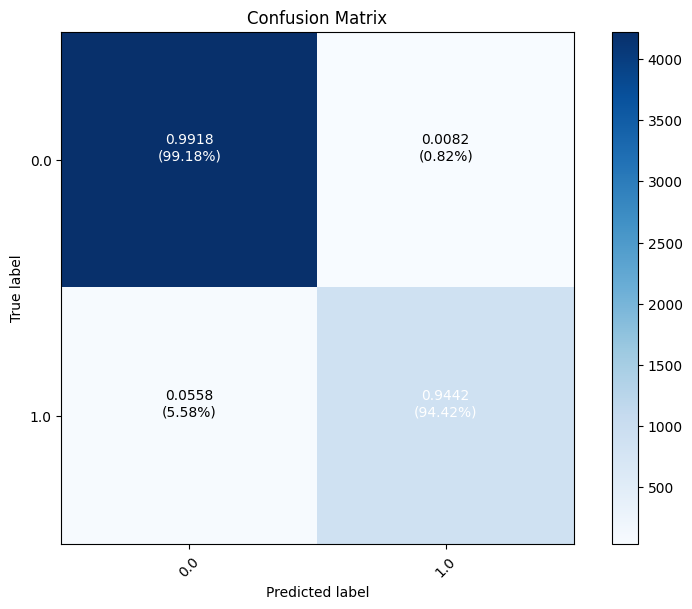

In [7]:
from sklearn.metrics import classification_report, ConfusionMatrixDisplay


class ModelValidator:
    """
    A class for validating machine learning models with various metrics.

    Attributes:
        model (estimator): The machine learning model to be validated.
        X_test (array-like): The test dataset features.
        y_test (array-like): The true labels corresponding to X_test.
    """

    def __init__(self, model, X_test, y_test):
        """
        The constructor for ModelValidator class.

        Parameters:
           model (estimator): The trained machine learning model.
           X_test (array-like): Features from the test dataset.
           y_test (array-like): True labels for the test dataset.
        """
        self.model = model
        self.X_test = X_test
        self.y_test = y_test

    def evaluate_performance(self):
        """
        Evaluates and prints the model's performance metrics.
        """
        y_pred = self.model.predict(self.X_test)
        f1 = f1_score(self.y_test, y_pred)
        conf_matrix = confusion_matrix(self.y_test, y_pred)
        tn, fp, fn, tp = conf_matrix.ravel()

        # Calculating False Positive Rate (FPR) and True Positive Rate (TPR)
        fpr = fp / (fp + tn) if (fp + tn) != 0 else 0
        tpr = tp / (tp + fn) if (tp + fn) != 0 else 0

        # Displaying basic metrics
        print(f"True Negatives (TN): {tn}")
        print(f"False Positives (FP): {fp}")
        print(f"False Negatives (FN): {fn}")
        print(f"True Positives (TP): {tp}\n")
        print(f"False Positive Rate (FPR): {fpr}")
        print(f"True Positive Rate (TPR): {tpr} (also known as Recall)\n")
        print(f"F1 Score: {f1:.4f}\n")

        # Display classification report
        print("Classification Report:")
        print(classification_report(self.y_test, y_pred, digits=4))

        # Plotting the confusion matrix
        self.plot_confusion_matrix(y_pred)

    def plot_confusion_matrix(self, y_pred):
        """
        Plots the confusion matrix of the model's predictions with enhanced visual detail.

        Parameters:
           y_pred (array-like): Predicted labels for the test dataset.
        """
        cm = confusion_matrix(self.y_test, y_pred, labels=self.model.classes_)
        plt.figure(figsize=(8, 6))
        plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
        plt.title('Confusion Matrix')
        plt.colorbar()
        tick_marks = np.arange(len(self.model.classes_))
        plt.xticks(tick_marks, self.model.classes_, rotation=45)
        plt.yticks(tick_marks, self.model.classes_)

        # Normalize the confusion matrix.
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

        # Annotating the confusion matrix with text
        thresh = cm.max() / 2.
        for i, j in np.ndindex(cm.shape):
            plt.text(j, i, f"{cm[i, j]:.4f}\n({cm[i, j]*100:.2f}%)",
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")

        plt.tight_layout()
        plt.ylabel('True label')
        plt.xlabel('Predicted label')
        plt.show()

# Example usage
validator = ModelValidator(model, svm_x_test, svm_y_test)
validator.evaluate_performance()